<a href="https://colab.research.google.com/github/pritampalit/ML4DQM/blob/master/Double_AE_Step_by_Step_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
import pandas as pd
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import json
#%matplotlib inline


#uploaded = files.upload()
#import io 
#df= pd.read_csv(io.BytesIO(uploaded['Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv']))
#df= pd.read_csv('ZeroBias_2017UL_DataFrame_ChargeInnerLayer4.txt')
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv')
df['histo']=df['histo'].apply(literal_eval)

df.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df.sort_index(inplace=True)
print(df['histo'].shape)
print(df.tail())
print(df.shape)

In [0]:
import seaborn as sns
from pylab import rcParams
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
import tensorflow
#from tensorflow import set_random_seed
tensorflow.random.set_seed(2)
#set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
DATA_SPLIT_PCT_VALID = 0.1
rcParams['figure.figsize'] = 10, 8




In [0]:
#add Golden JSON labels to the DF
import json

def checkLS(run,ls):
    isok=False
    global jsondata

    if str(run) in jsondata.keys():
        for i in jsondata[str(run)]:
            if (ls>=i[0] and ls <=i[1]):
                isok=True
                return isok
        return   isok

#load the golden json file
jsondata={}
with open('/content/drive/My Drive/Colab Notebooks/GoldenJSON17.json') as json_file:
    jsondata = json.load(json_file)

df['labels']=False #initialize to false

for run in df['fromrun'].unique():
    for ls in df['fromlumi'][run]:
        df['labels'][run][ls]=checkLS(run,ls)

#fname_bad = 'BAD_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.txt'
#fname_gold = 'GOLDEN_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv'
#df[df['labels']!=True].to_csv(fname_bad)
#df[df['labels']==True].to_csv(fname_gold)

#print(df[df['labels']!=True]) #to check against the Golden JSON
#print(df.shape)
#print(df['labels'])

# Type is just opposite of lables to take good as 0 and bad as 1 for the input of ROC & PR curves
df['type']=df['labels']
df['type']=df['type'].apply(lambda x:0 if x== True else 1)
df[df['type']==0]

# To initialize the Predictions and MSE column
df['predictions2']=""
df['mse2']=""


In [0]:
# Split total dataset into Train , Test and Validation (72:20:8)%
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT_VALID, random_state=SEED)

X_train_true = np.stack(df_train['histo'][df_train['labels']==True].values, axis=0)
X_train_false = np.stack(df_train['histo'][df_train['labels']==False].values, axis=0)

X_valid_true = np.stack(df_valid['histo'][df_valid['labels']==True].values, axis=0)
X_valid_false = np.stack(df_valid['histo'][df_valid['labels']==False].values, axis=0)


X_test_true = np.stack(df_test['histo'][df_test['labels']==True].values, axis=0)
X_test_false = np.stack(df_test['histo'][df_test['labels']==False].values, axis=0)

from sklearn.preprocessing import normalize

X_train_true_norm=normalize(X_train_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_train_false_norm=normalize(X_train_false, norm='l1', axis=1)

X_valid_true_norm=normalize(X_valid_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_valid_false_norm=normalize(X_valid_false, norm='l1', axis=1)

X_test_true_norm=normalize(X_test_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test_false_norm=normalize(X_test_false, norm='l1', axis=1)




In [0]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean

nb_epoch = 100
batch_size = 500
input_dim = X_train_true_norm.shape[1] #num of predictor variables, 
encoding_dim = 10
hidden_dim = 3
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)  
decoder = Dense(hidden_dim, activation="tanh")(encoder)
decoder = Dense(encoding_dim, activation="tanh")(decoder)
decoder = Dense(input_dim, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

In [0]:
autoencoder.compile(metrics=['accuracy'],
                    loss=mseTop10,
                    optimizer='adam')
cp = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_true_norm, X_train_true_norm,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_valid_true_norm, X_valid_true_norm),
                    verbose=1,
                    callbacks=[cp, tb]).history

In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

# "Loss"
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale("log")
plt.show()


In [0]:
#Details of Reconstruction error for Train dataset
# 'true class' of coulmn 'type' will help to classify '1' for Anomaly and '0' for Good, to draw ROC & P-R curves
'''
X_train_all = np.stack(df_train['histo'].values, axis=0)
X_train_all_norm=normalize(X_train_all, norm='l1', axis=1)

train_x_predictions = autoencoder.predict(X_train_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_train=K.eval(mseTop10(X_train_all_norm, train_x_predictions))
print(mse_train)
error_df_train = pd.DataFrame({'reconstruction_error': mse_train,
                        'true_class': df_train['type']})
error_df_train.describe()

#Details of Reconstruction error for Validation dataset
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
print(mse_valid)
error_df_valid = pd.DataFrame({'reconstruction_error': mse_valid,
                        'true_class': df_valid['type']})
error_df_valid.describe()
'''
X_test_all = np.stack(df_test['histo'].values, axis=0)
X_test_all_norm=normalize(X_test_all, norm='l1', axis=1)

df_test['origin']=''
df_test['origin']=X_test_all_norm.tolist()

test_x_predictions = autoencoder.predict(X_test_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_test=K.eval(mseTop10(X_test_all_norm, test_x_predictions))
print(mse_test)
error_df_test = pd.DataFrame({'reconstruction_error': mse_test,
                        'true_class': df_test['type']})
error_df_test.describe()


In [0]:
# Fill the predictions and MSE column
df_test['prediction2']=test_x_predictions.tolist()
df_test['mse2']=mse_test
print(df_test.head())

In [0]:
def CheckAllPredictions(df_test, run, ls):

    Xmax=80000.0
    Xmin=0.0
    Xbins=100
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    #ahisto1=df_test['prediction'][run][ls]
    ahisto2=df_test['prediction2'][run][ls]
    #mse=df_test['mse'][run][ls]
    mse2=df_test['mse2'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" LS : " + str(df_test.fromlumi[run][ls]) + " Run : " + str(df_test.fromrun[run][ls]) ))
    #plt.step(x, ahisto1, where='mid', label=" Raw Reco, mse:" + str(mse))
    plt.step(x, ahisto2, where='mid', label=" Reco, mse:" + str(mse2))
    plt.xlabel("Charge electrons")
    plt.ylabel("A.U")
    plt.legend(bbox_to_anchor=(0, 1), loc='lower right', ncol=1)
    plt.show()

In [0]:
rcParams['figure.figsize'] = 3, 3
for run in df_test['fromrun'].unique():
    count=0
    #if run <298000: continue
    for ls in df_test['fromlumi'][run]: 
        #if df['train'][run][ls]== True: continue
        #if ((df_test['mse2'][run][ls]<0.0007) or (df_test['mse2'][run][ls] > 0.0009)) : continue
        if df_test['mse2'][run][ls] > 0.0002 : continue
        #if df['entries'][run][ls]<3000: continue
        #if (count >2): continue
        count=count+1
        #print(df.entries)[run][ls]
        CheckAllPredictions(df_test, run,ls)

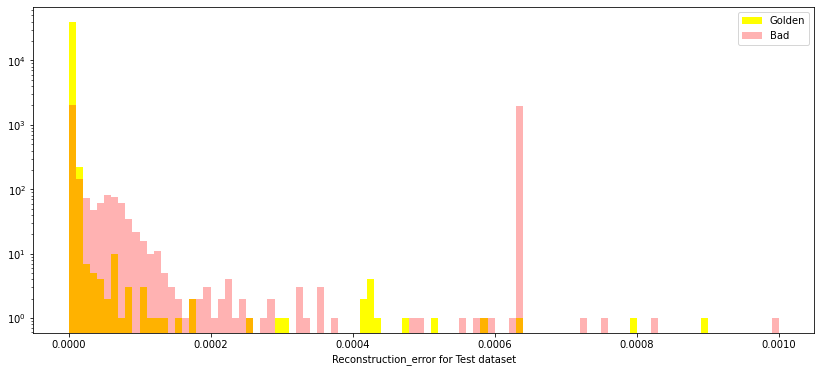

In [0]:
# To plot Distribution of Reconstruction Error (Here mseTop10)
rcParams['figure.figsize'] = 14, 6
Anomaly_error_df_train = error_df_train[(error_df_train['true_class']== True)]
Golden_error_df_train = error_df_train[(error_df_train['true_class']== False)]
Anomaly_error_df_valid = error_df_valid[(error_df_valid['true_class']== True)]
Golden_error_df_valid = error_df_valid[(error_df_valid['true_class']== False)]
Anomaly_error_df_test = error_df_test[(error_df_test['true_class']== True)]
Golden_error_df_test = error_df_test[(error_df_test['true_class']== False)]
'''
fig = plt.figure(1)
#ax = fig.add_subplot(131)
ax = fig.add_subplot()
ax.hist(Golden_error_df_train.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'Train : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_train.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Train : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Train dataset')
plt.legend(['Golden', 'Bad'], loc='upper right')
fig = plt.figure(2)
#ax = fig.add_subplot(132)
ax = fig.add_subplot()
ax.hist(Golden_error_df_valid.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'validation : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_valid.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Validation : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Validation dataset')
plt.legend(['Golden', 'Bad'], loc='upper right')
'''
fig = plt.figure(3)
#ax = fig.add_subplot(133)
ax = fig.add_subplot()
ax.hist(Golden_error_df_test.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'Test : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_test.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Test : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Test dataset')
#ax.set_alpha(0.9)
#plt.tight_layout()
plt.legend(['Golden', 'Bad'], loc='upper right')
plt.show()








[0.         0.         0.         ... 0.99513532 0.99513532 1.        ]
[0.00000000e+00 2.12992545e-04 1.27795527e-03 ... 9.99787007e-01
 1.00000000e+00 1.00000000e+00]
[1.00396390e+00 3.96390203e-03 9.94459149e-04 ... 2.92434497e-07
 2.92253390e-07 1.68940575e-07]
Best Threshold=0.000004, G-Mean=0.758


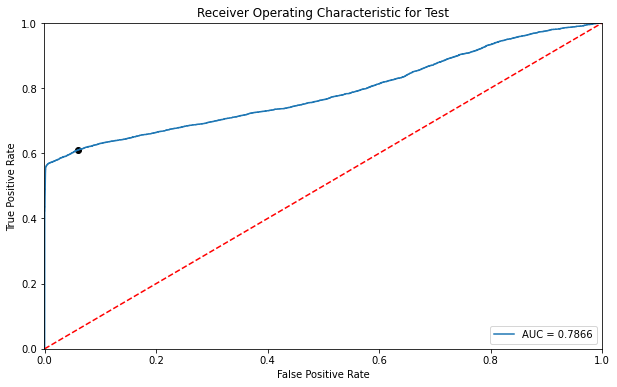

In [0]:
#Plot ROC Curves
rcParams['figure.figsize'] = 10, 6
'''
#ROC for Train
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_train.true_class, error_df_train.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(1)
#plt.subplot(1,3,1)
plt.title('Receiver Operating Characteristic for Train')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show();


#ROC for Validation
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_valid.true_class, error_df_valid.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(2)
#plt.subplot(1,3,2)
plt.title('Receiver Operating Characteristic for Validation')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show();
'''

# ROC for test
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
fig = plt.figure(3)
#plt.subplot(1,3,3)
plt.title('Receiver Operating Characteristic for Test')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Best Threshold=0.000013, F-Score=0.709


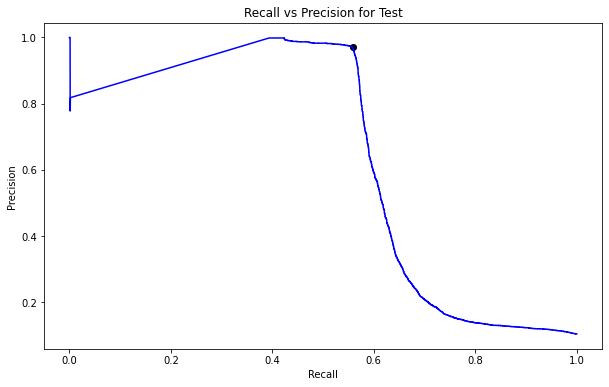

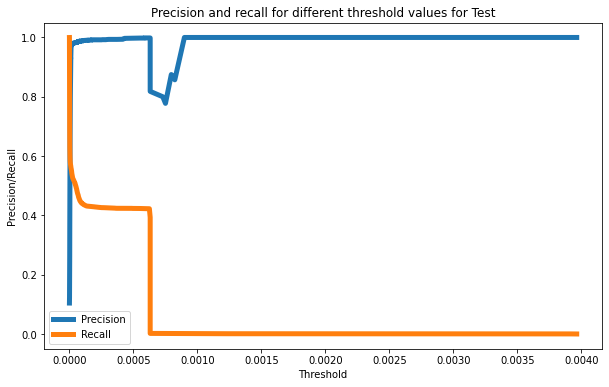

In [0]:
# P-R curve and G-Mean calculation

rcParams['figure.figsize'] = 10, 6
from numpy import argmax
'''
#P-R curve for train
precision, recall, th = precision_recall_curve(error_df_train.true_class, error_df_train.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
print(fscore)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
plt.figure(1)
#plt.subplot(2,3,1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Train')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(2)
#plt.subplot(2,3,4)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Train')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()



#P-R curve for validation
precision, recall, th = precision_recall_curve(error_df_valid.true_class, error_df_valid.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
plt.figure(3)
#plt.subplot(2,3,2)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(4)
#plt.subplot(2,3,5)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Validation')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()
'''


#P-R curve for test
precision, recall, th = precision_recall_curve(error_df_test.true_class, error_df_test.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f1 score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
plt.figure(5)
#plt.subplot(2,3,3)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(6)
#plt.subplot(2,3,6)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Test')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

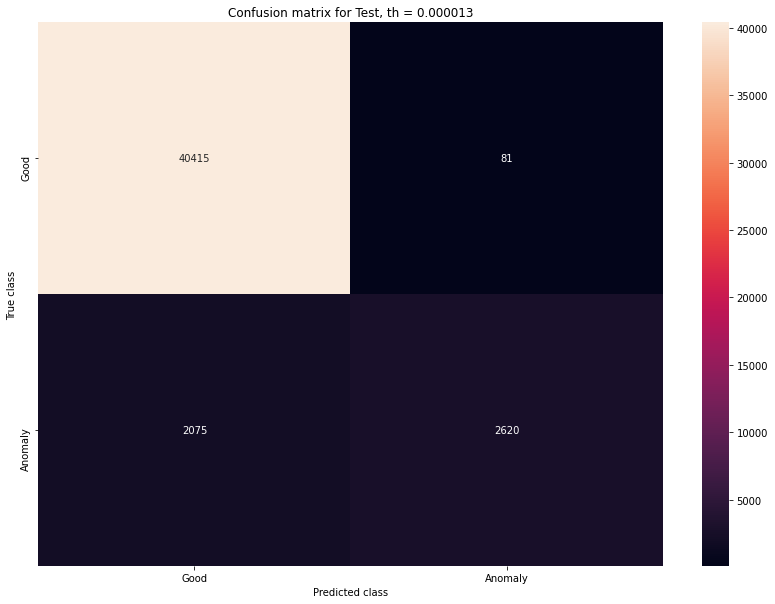

In [0]:
# Confusion Matrix to get the Actual Class vs Predicted Class
rcParams['figure.figsize'] = 14, 10
'''
#confusion matrix for train
import seaborn as sns
threshold_train = th[ix]
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold_train else 0 for e in error_df_train.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_train.true_class, y_pred)
plt.figure(1)
#plt.subplot(1,3,1)
#plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Train, th = %f" % (th[ix]))
plt.ylabel('True class')
plt.xlabel('Predicted class')
#plt.show()

#confusion matrix for validation
#import seaborn as sns
threshold_valid = th[ix]
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold_valid else 0 for e in error_df_valid.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_valid.true_class, y_pred)
#plt.figure(figsize=(12, 12))
#plt.subplot(1,3,2)
plt.figure(2)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Validation, th = %f " % (th[ix]) )
plt.ylabel('True class')
plt.xlabel('Predicted class')
#plt.show()
'''

#confusion matrix for test
#import seaborn as sns
threshold = th[ix] # Be cautious about using th[ix] before omitting the previous comment outs
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class, y_pred)
#plt.figure(figsize=(12, 12))
plt.figure(3)
#plt.subplot(1,3,3)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Test, th = %f" % (th[ix]))
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
# Find error for the whole dataset
X_all = np.stack(df['histo'].values, axis=0)
X_all_good = np.stack(df['histo'][df['labels']==True].values, axis=0)
X_all_bad = np.stack(df['histo'][df['labels']==False].values, axis=0)
X_all_norm=normalize(X_all, norm='l1', axis=1)
X_all_good_norm=normalize(X_all_good, norm='l1', axis=1)
X_all_bad_norm=normalize(X_all_bad, norm='l1', axis=1)

x_predictions = autoencoder.predict(X_all_norm)
x_good_predictions = autoencoder.predict(X_all_good_norm)
x_bad_predictions = autoencoder.predict(X_all_bad_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_all=K.eval(mseTop10(X_all_norm, x_predictions))
mse_good_all=K.eval(mseTop10(X_all_good_norm, x_good_predictions))
mse_bad_all=K.eval(mseTop10(X_all_bad_norm, x_bad_predictions))
#mse_test=np.mean(np.power(X_test_all_norm - test_x_predictions, 2), axis=1)
print(mse_all)
error_df_all = pd.DataFrame({'reconstruction_error': mse_all,
                        'true_class': df['type']})
error_df_all.describe()


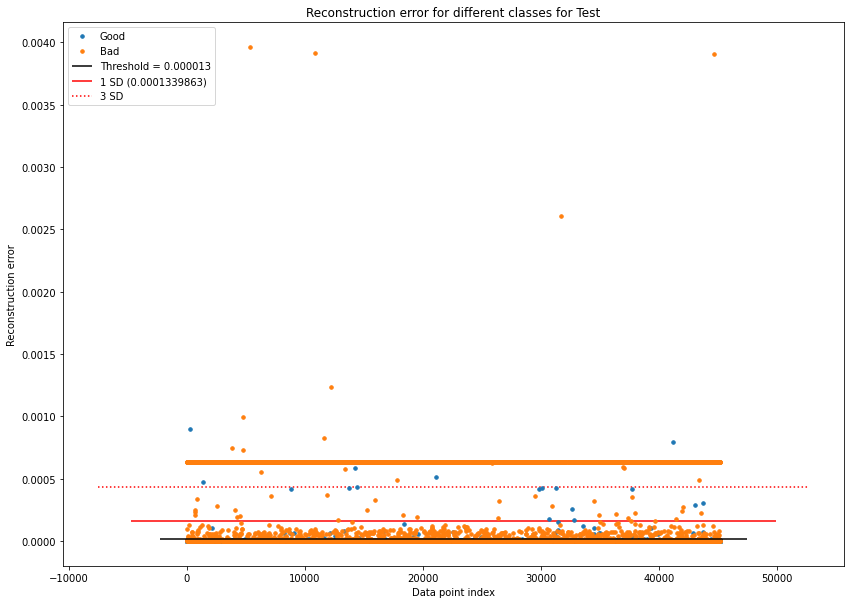

In [0]:
# The Scatter plot of Reconstruction errors over all indices

rcParams['figure.figsize'] = 14, 10
'''
#Scatter plot for Train
error_df_train = error_df_train.reset_index(drop=True)
threshold_fixed_train = th[ix]
groups = error_df_train.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Anomaly" if name == 1 else "Good")
ax.hlines(threshold_fixed_train, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold = 0.000014')
ax.legend()
plt.title("Reconstruction error for different classes for Train")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.show();

#Scatter plot for Validation
error_df_valid = error_df_valid.reset_index(drop=True)
threshold_fixed_valid = 0.000014
groups = error_df_valid.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Anomaly" if name == 1 else "Good")
ax.hlines(threshold_fixed_valid, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold = 0.000014')
ax.legend()
plt.title("Reconstruction error for different classes for Valid")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.show();
'''

#Scatter plot for test (including both the good and bad runs)
error_df_test = error_df_test.reset_index(drop=True)
threshold_fixed_test = th[ix]
groups = error_df_test.groupby('true_class')
gmean= 3.100298e-05 # from error_*.describe()
gstd = 1.339863e-04
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Bad" if name == 1 else "Good")
ax.hlines(threshold_fixed_test, ax.get_xlim()[0], ax.get_xlim()[1], colors="k", zorder=100, label='Threshold = %f' % (th[ix]))
#ax.hlines(gmean, ax.get_xlim()[0], ax.get_xlim()[1], color="blue", label="Run average: " + str(gmean))
ax.hlines(gmean+(1.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='1 SD (' + str(gstd) + ")")
ax.hlines(gmean+(3.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='3 SD', linestyle=':')    
ax.legend()
plt.title("Reconstruction error for different classes for Test")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();



In [0]:
df['mse2']=mse_all
df['mse2'].loc[df['labels']==True]=mse_good_all
df['mse2'].loc[df['labels']==False]=mse_bad_all
def globalMSETrendAll(df):
    dff = df[df.labels==False]
    yf=[]
    #print (dff.head())
    rmax=0
    rmin=10
    
    #print(rmax, rmin)
    for run in dff['fromrun'].unique():
        #if (type==1): val=(dff['mse'][run]).mean()
        val=(dff['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        yf.append(val)
    
    arrayf=np.array(yf)
    gmeanf=arrayf.mean()
    sizef=float(arrayf.size)
    gstdf=arrayf.std()
    print(sizef)
##################
    dft = df[df.labels==True]
    y=[]
    
    rmax=0
    rmin=10
    
    print(rmax, rmin)
    for run in dft['fromrun'].unique():
        #if (type==1): val=(dft['mse'][run]).mean()
        val=(dft['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        y.append(val)
    
    array=np.array(y)
    gmean=array.mean()
    size=float(array.size)
    gstd=array.std()
    print(size)
    
#######################

    fig=plt.figure()
    fig.set_size_inches(16, 9)
    
    plt.hlines(gmean,dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), color="blue", label="Good Run average: %.9f" % (gmean))
    plt.hlines(threshold_fixed_test, dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), colors="k", zorder=100, label='Threshold = %f' % (threshold_fixed_test) )
    plt.hlines(gmean+(1.0*gstd), dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), color="red", label='1 SD ( %.9f' % (gstd) + ")")
    plt.hlines(gmean+(3.0*gstd), dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), color="red", label='3 SD', linestyle=':')
    
    plt.hlines(gmeanf,dff['fromrun'].unique().min(), dff['fromrun'].unique().max(), color="green", label="Bad Run average: %.9f" % (gmeanf))
    #plt.hlines(gmeanf+(1.0*gstd), dff['fromrun'].unique().min(), dff['fromrun'].unique().max(), color="green", label='1 SD (' + str(gstdf) + ")")
    #plt.hlines(gmeanf+(3.0*gstd), dff['fromrun'].unique().min(), dff['fromrun'].unique().max(), color="green", label='3 SD', linestyle=':')
    
    
    #plt.ylim(rmin*0.9,rmax*1.1)
    plt.ylim([0.0,0.0007])
    plt.scatter(dft['fromrun'].unique(), y, marker='+', label='Good Data points')
    plt.scatter(dff['fromrun'].unique(), yf, marker='+', label='Bad Data points',color="yellow")
    plt.xlabel("Run")
    plt.ylabel("average MSE")
    plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)
    plt.show()
	


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


465.0
0 10
469.0


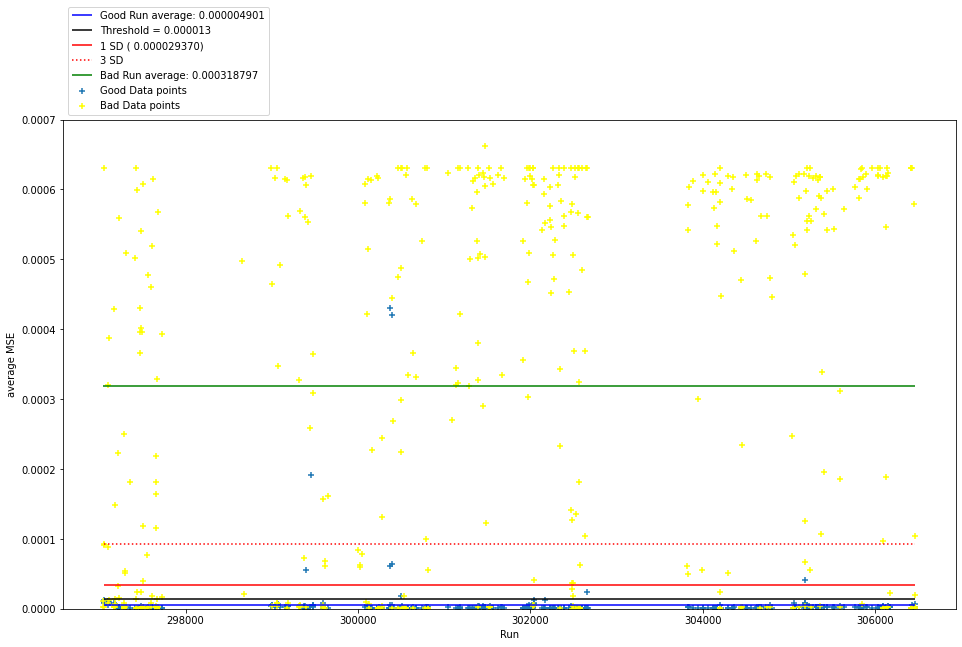

In [0]:
globalMSETrendAll(df)

In [0]:
#### Standard Autoencoder with ROC, PR Curve, COnfusion Matrix and Scatter plots are upto this. Left are for LSTM

In [0]:
print(X_train_true_norm.shape)
print(X_valid_true_norm.shape)
print(X_test_true_norm.shape)

In [0]:
#LSTM
from numpy import array
from keras.models import Sequential
from keras.models import Sequential
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers.advanced_activations import ReLU
from keras import backend as K

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean

lr = 0.0001
# reshape input into [samples, timesteps, features]
timesteps = len(X_train_true_norm[0])
n_samples = X_train_true_norm.shape[0]
n_features = 1
X_train_lstm = X_train_true_norm.reshape((n_samples, timesteps, 1))
print(X_train_lstm.shape)

timesteps_valid = len(X_valid_true_norm[0])
n_samples_valid = X_valid_true_norm.shape[0]
n_features = 1
X_valid_lstm = X_valid_true_norm.reshape((n_samples_valid, timesteps_valid, 1))

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(10, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(3, activation='tanh', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(3, activation='tanh', return_sequences=True))
lstm_autoencoder.add(LSTM(10, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()



In [0]:
epochs=2
batch=500

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/lstm_logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_lstm, X_train_lstm, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_lstm, X_valid_lstm),
                                                verbose=2).history

In [0]:
print(X_train_true_norm.shape)
print(X_valid_true_norm.shape)
print(X_test_true_norm.shape)


(145591, 100)
(16212, 100)
(40496, 100)


In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

# "Loss"
plt.figure(1)
plt.plot(lstm_autoencoder_history['loss'])
plt.plot(lstm_autoencoder_history['val_loss'])
plt.title('model loss for LSTM AE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale("log")
#plt.xlim(0,100)
plt.show()

#plot_loss(history, "Original model loss")

In [0]:
X_train_all = np.stack(df_train['histo'].values, axis=0)
X_train_all_norm=normalize(X_train_all, norm='l1', axis=1)

train_x_predictions = lstm_autoencoder.predict(X_train_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_train=K.eval(mseTop10(X_train_all_norm, train_x_predictions))
print(mse_train)
error_df_train = pd.DataFrame({'reconstruction_error': mse_train,
                        'true_class': df_train['type']})
error_df_train.describe()


In [0]:
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = lstm_autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
print(mse_valid)
error_df_valid = pd.DataFrame({'reconstruction_error': mse_valid,
                        'true_class': df_valid['type']})
error_df_valid.describe()


In [0]:
X_test_all = np.stack(df_test['histo'].values, axis=0)
X_test_all_norm=normalize(X_test_all, norm='l1', axis=1)

test_x_predictions = lstm_autoencoder.predict(X_test_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_test=K.eval(mseTop10(X_test_all_norm, test_x_predictions))
print(mse_valid)
error_df_test = pd.DataFrame({'reconstruction_error': mse_test,
                        'true_class': df_test['type']})
error_df_test.describe()

In [0]:
rcParams['figure.figsize'] = 14, 6
'''
# reconstruction error for the normal transactions in the testing dataset
fig = plt.figure(1)
ax = fig.add_subplot(111)
Anomaly_error_df_valid = error_df_valid[(error_df_valid['true_class']== True)]
Golden_error_df_valid = error_df_valid[(error_df_valid['true_class']== False)]
ax.hist(Golden_error_df_valid.reconstruction_error.values, bins=1000, range=(0., 0.0002), color = 'yellow', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_valid.reconstruction_error.values, bins=1000, range=(0., 0.0002), color = 'red', ls='dashed',  alpha = 0.3, lw=3, log=True)
#ax.set_alpha(0.9)
plt.show()
'''
# reconstruction error for the normal transactions in the testing dataset
#rcParams['figure.figsize'] = 10, 8
Anomaly_error_df_train = error_df_train[(error_df_train['true_class']== True)]
Golden_error_df_train = error_df_train[(error_df_train['true_class']== False)]
Anomaly_error_df_valid = error_df_valid[(error_df_valid['true_class']== True)]
Golden_error_df_valid = error_df_valid[(error_df_valid['true_class']== False)]
Anomaly_error_df_test = error_df_test[(error_df_test['true_class']== True)]
Golden_error_df_test = error_df_test[(error_df_test['true_class']== False)]
fig = plt.figure(1)
#ax = fig.add_subplot(131)
ax = fig.add_subplot()
ax.hist(Golden_error_df_train.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'Train : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_train.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Train : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Train dataset')
plt.legend(['Golden', 'Bad'], loc='upper right')
fig = plt.figure(2)
#ax = fig.add_subplot(132)
ax = fig.add_subplot()
ax.hist(Golden_error_df_valid.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'validation : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_valid.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Validation : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Validation dataset')
plt.legend(['Golden', 'Bad'], loc='upper right')
fig = plt.figure(3)
#ax = fig.add_subplot(133)
ax = fig.add_subplot()
ax.hist(Golden_error_df_test.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'Test : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_test.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Test : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Test dataset')
#ax.set_alpha(0.9)
#plt.tight_layout()
plt.legend(['Golden', 'Bad'], loc='upper right')
plt.show()


In [0]:
rcParams['figure.figsize'] = 10, 6
#ROC for Train
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_train.true_class, error_df_train.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(1)
#plt.subplot(1,3,1)
plt.title('Receiver Operating Characteristic for Train')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show();


#ROC for Validation
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_valid.true_class, error_df_valid.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(2)
#plt.subplot(1,3,2)
plt.title('Receiver Operating Characteristic for Validation')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show();

# ROC for test
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
fig = plt.figure(3)
#plt.subplot(1,3,3)
plt.title('Receiver Operating Characteristic for Test')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [0]:
rcParams['figure.figsize'] = 10, 6
from numpy import argmax
#P-R curve for train
precision, recall, th = precision_recall_curve(error_df_train.true_class, error_df_train.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = argmax(fscore)
#print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.figure(1)
#plt.subplot(2,3,1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Train')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(2)
#plt.subplot(2,3,4)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Train')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()



#P-R curve for validation
precision, recall, th = precision_recall_curve(error_df_valid.true_class, error_df_valid.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = argmax(fscore)
#print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.figure(3)
#plt.subplot(2,3,2)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(4)
#plt.subplot(2,3,5)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Validation')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()


#P-R curve for test
precision, recall, th = precision_recall_curve(error_df_test.true_class, error_df_test.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f1 score
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ix = argmax(fscore)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
plt.figure(5)
#plt.subplot(2,3,3)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(6)
#plt.subplot(2,3,6)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Test')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [0]:
rcParams['figure.figsize'] = 12, 12
#confusion matrix for train
import seaborn as sns
threshold_train = 0.000014
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold_train else 0 for e in error_df_train.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_train.true_class, y_pred)
plt.figure(1)
#plt.subplot(1,3,1)
#plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Train, th = 0.000014")
plt.ylabel('True class')
plt.xlabel('Predicted class')
#plt.show()

#confusion matrix for validation
#import seaborn as sns
threshold_valid = 0.000010
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold_valid else 0 for e in error_df_valid.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_valid.true_class, y_pred)
#plt.figure(figsize=(12, 12))
#plt.subplot(1,3,2)
plt.figure(2)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Validation, th = 0.000014")
plt.ylabel('True class')
plt.xlabel('Predicted class')
#plt.show()

#confusion matrix for test
#import seaborn as sns
threshold = 0.000010
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class, y_pred)
#plt.figure(figsize=(12, 12))
plt.figure(3)
#plt.subplot(1,3,3)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Test, th = 0.000014")
plt.ylabel('True class')
plt.xlabel('Predicted class')

#confusion matrix for test
#import seaborn as sns
threshold = 0.000010
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class, y_pred)
#plt.figure(figsize=(12, 12))
plt.figure(3)
#plt.subplot(1,3,3)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Test, th = 0.000014")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
rcParams['figure.figsize'] = 14, 10
#Scatter plot for Train
error_df_train = error_df_train.reset_index(drop=True)
threshold_fixed_train = 0.000014
groups = error_df_train.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Anomaly" if name == 1 else "Good")
ax.hlines(threshold_fixed_train, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold = 0.000014')
ax.legend()
plt.title("Reconstruction error for different classes for Train")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.show();

#Scatter plot for Validation
error_df_valid = error_df_valid.reset_index(drop=True)
threshold_fixed_valid = 0.000014
groups = error_df_valid.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Anomaly" if name == 1 else "Good")
ax.hlines(threshold_fixed_valid, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold = 0.000014')
ax.legend()
plt.title("Reconstruction error for different classes for Valid")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.show();

error_df_test = error_df_test.reset_index(drop=True)
threshold_fixed_test = 0.000014
groups = error_df_test.groupby('true_class')
gmean= 3.100298e-05 
gstd = 1.339863e-04
fig, ax = plt.subplots()


for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Bad" if name == 1 else "Good")
ax.hlines(threshold_fixed_test, ax.get_xlim()[0], ax.get_xlim()[1], colors="k", zorder=100, label='Threshold = 0.000014')
#ax.hlines(gmean, ax.get_xlim()[0], ax.get_xlim()[1], color="blue", label="Run average: " + str(gmean))
ax.hlines(gmean+(1.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='1 SD (' + str(gstd) + ")")
ax.hlines(gmean+(3.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='3 SD', linestyle=':')    
ax.legend()
plt.title("Reconstruction error for different classes for Test")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [0]:
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
error_df = pd.DataFrame({'Reconstruction_error': mse_valid,
                        'True_class': df_valid['labels']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()